<a href="https://colab.research.google.com/github/Ariostgx/fairgen/blob/main/docs/fairgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Codebase and Models

In [ ]:
#@title Click left to featch code and models
import os
os.chdir('/content')

# # featch model codebase
CODE_DIR = 'fairgen'
os.makedirs(f'./{CODE_DIR}', exist_ok=True)
!git clone https://github.com/Ariostgx/fairgen_model.git $CODE_DIR
os.chdir('/content/fairgen')

# fetch GMM models
if not os.path.exists('/content/gmm_small/age_smiling_gmm.p'):
  !gdown https://drive.google.com/uc?id=1-Qfw4KGkm3EU0YzmAifc4w-7Q95ZAvom -O /content/gmm.zip
  !unzip /content/gmm.zip -d /

# Define Utility Functions


In [2]:
#@title Click left to setup utility functions
import subprocess
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image
import torch
import pickle
import sklearn.mixture

from models import MODEL_ZOO
from models import build_generator

import warnings
warnings.filterwarnings("ignore")

value_name = {'Age': {-1: 'Young', 1: 'Adult'}, 'Gender': {-1: 'Male', 1: 'Female'}, 'Smiling': {-1: 'With', 1: 'Without'}}
for attr in ['Eyeglasses', 'Black_Hair']:
  value_name[attr] = value_name['Smiling']

def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col
  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)
  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image
  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

def build(model_name, use_cuda=False):
  """Builds generator and load pre-trained weights."""
  model_config = MODEL_ZOO[model_name].copy()
  url = model_config.pop('url')  # URL to download model if needed.

  # Build generator.
  print(f'Building generator for model `{model_name}` ...')
  generator = build_generator(**model_config, use_cuda = use_cuda)
  print(f'Finish building generator.')

  # Load pre-trained weights.
  os.makedirs('checkpoints', exist_ok=True)
  checkpoint_path = os.path.join('checkpoints', model_name + '.pth')
  print(f'Loading checkpoint from `{checkpoint_path}` ...')
  if not os.path.exists(checkpoint_path):
    print(f'  Downloading checkpoint from `{url}` ...')
    subprocess.call(['wget', '--quiet', '-O', checkpoint_path, url])
    print(f'  Finish downloading checkpoint.')
  checkpoint = torch.load(checkpoint_path, map_location='cpu')
  if 'generator_smooth' in checkpoint:
    generator.load_state_dict(checkpoint['generator_smooth'])
  else:
    generator.load_state_dict(checkpoint['generator'])
  if use_cuda:
      generator = generator.cuda()
  generator.eval()
  print(f'Finish loading checkpoint.')
  return generator

def sample_codes(generator, num):
  """Samples latent codes randomly."""
  codes = generator.easy_sample(num)
  codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
  codes = generator.get_value(generator.mapping(codes, None)['w'])
  return codes


def gmm_model_from_param(gmm_params):
  gmm_model = sklearn.mixture.GaussianMixture(init_params = gmm_params['params'])
  gmm_model.covariances_ = gmm_params['cov']
  gmm_model.means_ = gmm_params['mean']
  gmm_model.weights_ = gmm_params['weights']

  return gmm_model

loaded_pair = ''

# Build GAN model

In [3]:
model_name = 'stylegan2_ffhq1024'
generator = build(model_name, use_cuda=True)

Building generator for model `stylegan2_ffhq1024` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan2_ffhq1024.pth` ...
Finish loading checkpoint.


# Direct sample images from GAN

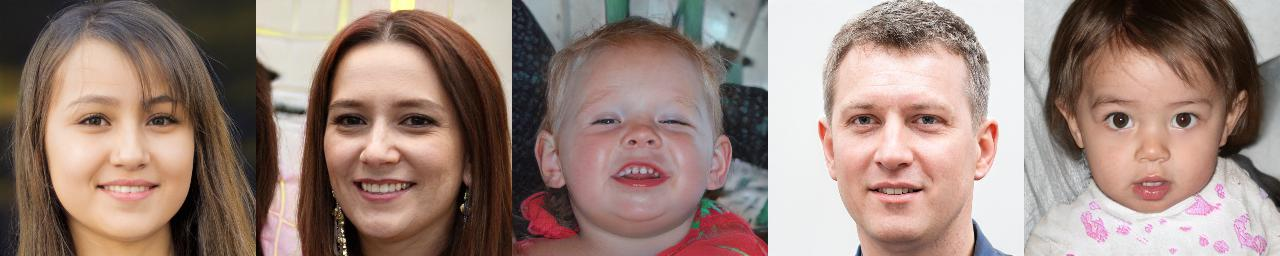

In [4]:

#@title { display-mode: "form", run: "auto" }

num_samples = 5 #@param {type:"slider", min:1, max:8, step:1}
codes = sample_codes(generator, num_samples)

with torch.no_grad():
  images = generator(codes, latent_space_type='W')['image']
imshow(images, col=num_samples)

# Select one of the attribute pairs



In [5]:
#@title { display-mode: "form", run: "auto" }
attribute_pair = "Gender vs Eyeglasses" #@param ['Age vs Eyeglasses','Age vs Gender', 'Age vs Smiling', 'Gender vs Black_Hair', 'Gender vs Eyeglasses']

attr_names = attribute_pair.lower().split(' ')
attr_pair_name = "{}_{}".format(attr_names[0], attr_names[2])

if loaded_pair != attribute_pair:
  gmm_path = f'/content/gmm_small/{attr_pair_name}_gmm.p'
  gmm_params = pickle.load(open(gmm_path, 'rb'))
  loaded_pair = attribute_pair

  gmm_models = {}
  for name, gmm_param in gmm_params.items():
    gmm_models[name] = gmm_model_from_param(gmm_param)

# Conditional sample subgroup images



---


| Attribute | value=-1 | value=1 |
|-----|-----|-----|
| <img width=100/>Age<img width=100/> | <img width=50/>young<img width=50/> | <img width=50/>adult<img width=50/> |
| <img width=100/>Gender<img width=100/> | <img width=50/>male<img width=50/> | <img width=50/>female<img width=50/> |
| <img width=100/>Eyeglasses<img width=100/> | <img width=50/>with<img width=50/> | <img width=50/>without<img width=50/> |
| <img width=100/>Black Hair<img width=100/> | <img width=50/>with<img width=50/> | <img width=50/>without<img width=50/> |
| <img width=100/>Smiling<img width=100/> | <img width=50/>with<img width=50/> | <img width=50/>without<img width=50/> |


Female Gender and With Eyeglasses


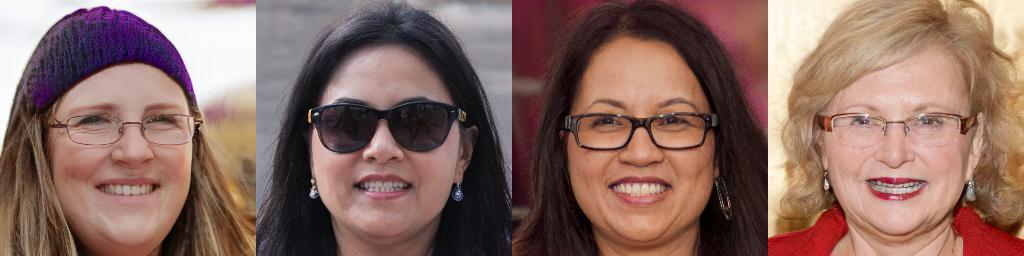

In [6]:

#@title { display-mode: "form", run: "auto" }
#@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
attr_1_value = "1" #@param ['-1', '1']
attr_2_value = "-1" #@param ['-1', '1']
attr_1,_,attr_2 = attribute_pair.split(' ')

attr_value_name = '{:.1f}_{:.1f}'.format(int(attr_1_value)*3.0, int(attr_2_value)*3.0)
gmm_model = gmm_models[attr_value_name]
codes = gmm_model.sample(num_samples)[0]

print("{} {} and {} {}".format(value_name[attr_1][int(attr_1_value)], attr_1, value_name[attr_2][int(attr_2_value)], attr_2))

with torch.no_grad():
  images = generator(codes, latent_space_type='W')['image']
imshow(images, col=num_samples)

# Fair sample of the specified attribute pair


Male Gender and With Eyeglasses


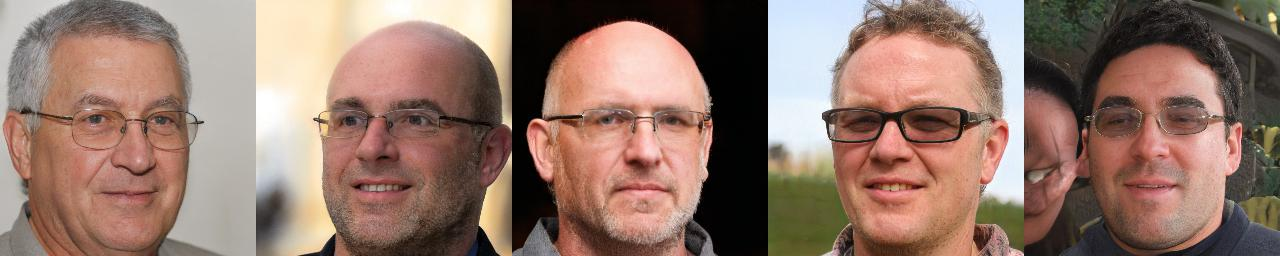

Male Gender and Without Eyeglasses


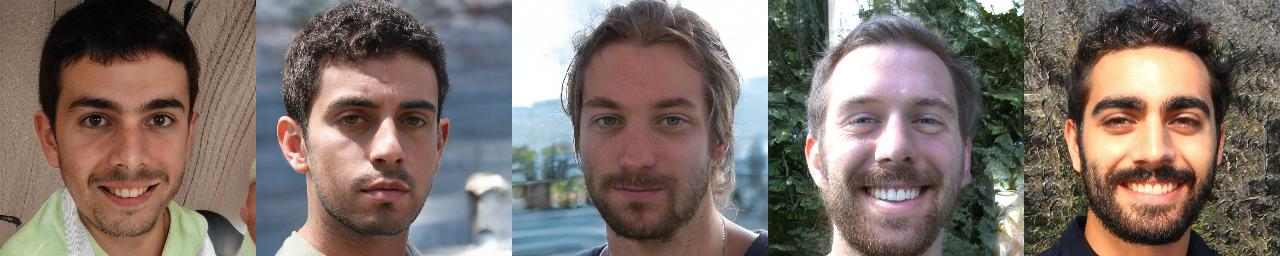

Female Gender and With Eyeglasses


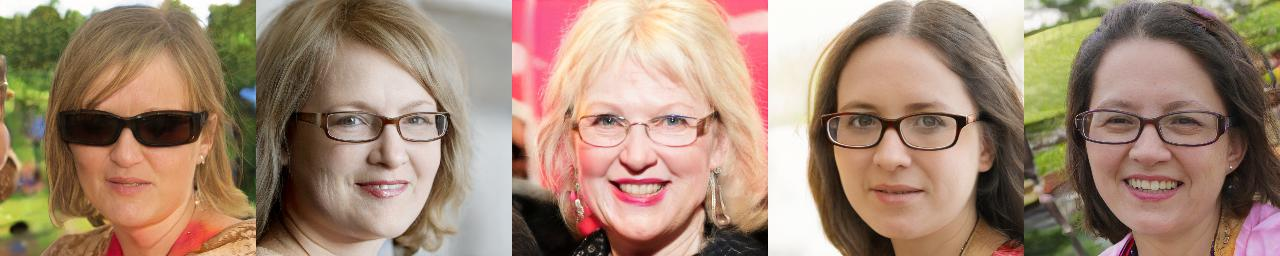

Female Gender and Without Eyeglasses


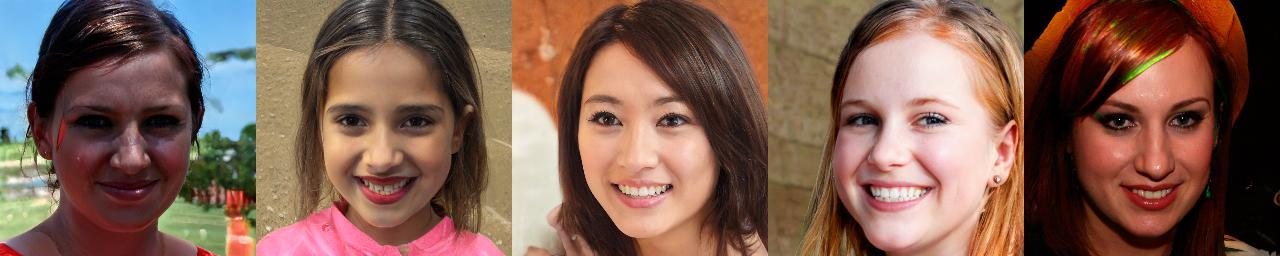

In [7]:
#@title { display-mode: "form", run: "auto" }
num_samples = 5 #@param {type:"slider", min:1, max:8, step:1}

for attr_1_value in [-1, 1]:
  for attr_2_value in [-1, 1]:
    print("{} {} and {} {}".format(value_name[attr_1][attr_1_value], attr_1, value_name[attr_2][attr_2_value], attr_2))

    attr_value_name = '{:.1f}_{:.1f}'.format(int(attr_1_value)*3.0, int(attr_2_value)*3.0)
    gmm_model = gmm_models[attr_value_name]
    codes = gmm_model.sample(num_samples)[0]
    with torch.no_grad():
      images = generator(codes, latent_space_type='W')['image']
    imshow(images, col=num_samples)